# Dijkstra from scratch
https://joshuacclark.medium.com/dijkstras-algorithm-with-adjacency-lists-ae2e9301d315

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 

import heapq

from sklearn.preprocessing import StandardScaler

from scipy.special import betainc

from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
test = False

In [3]:
class SearchEdge:

    def __init__(self,adj_mat:np.ndarray):
        self.adj_mat=adj_mat
        self.adj_list = self.adjacenty_from_matrix_to_list(adj_mat)
        self.n = len(self.adj_list)
        self.start_node = None
        self.previous_nodes = None
        self.dist = None

    def adjacenty_from_matrix_to_list(self,adj_mat:np.ndarray) -> defaultdict:

        adj_list = defaultdict(list)

        for i,j in zip(*np.where(np.triu(adj_mat))):
            adj_list[i].append([j,adj_mat[i,j]])
            adj_list[j].append([i,adj_mat[j,i]])

        return adj_list

    def min_distance(self, dist:list, seen:set):

        min_dist = float('inf')

        for i in range(len(self.adj_list)):
            if i not in seen and dist[i] < min_dist: # Avoid to turn
                min_d = dist[i]
                min_node = i
                
        return min_node
                
    def slow_dijkstra(self,start):

        dist = [float('inf')]*len(self.adj_list)
        seen=set()
        dist[start]=0

        for _ in range(len(self.adj_list)):
            current_node = self.min_distance(dist, seen)
            seen.add(current_node)

            for node, weight in self.adj_list[current_node]:
                if node not in seen and dist[node] > dist[current_node] + weight:
                    dist[node] = dist[current_node] + weight

    def dijkstra_optim(self, start_node:int=None, depth_lim:int=0, inplace:bool=True):

        if self.start_node is None:
            self.start_node = start_node

        if start_node is not None and self.start_node != start_node:
            self.start_node = start_node
        
        dist = [float('inf')] * self.n
        seen = set()
        heap = []
        dist[self.start_node] = 0
        depth_tracker = [0] * self.n
        previous_nodes = [None] * self.n

        if depth_lim <= 0:
            depth_lim = self.n

        heapq.heappush(heap, (self.start_node, dist[self.start_node],depth_tracker[self.start_node]))

        while len(heap) > 0:
            node, current_dist, current_depth = heapq.heappop(heap)

            seen.add(node)

            for neighbor, w in self.adj_list[node]:
                if neighbor not in seen:
                    new_dist = current_dist + w
                    new_depth = current_depth + 1

                    if new_depth > depth_lim:
                        heapq.heappush(heap, (neighbor, float('inf'), 0))
                    elif new_dist < dist[neighbor]:
                        dist[neighbor] = new_dist
                        depth_tracker[neighbor] = new_depth
                        previous_nodes[neighbor] = node
                        heapq.heappush(heap, (neighbor, new_dist, new_depth))

        if inplace:
            self.dist=dist
            self.previous_nodes = previous_nodes
        else :
            return dist, previous_nodes

    def get_path(self,end_node,previous_nodes=None,start_node=None):

        if previous_nodes is None:
            previous_nodes = self.previous_nodes

        if start_node is None:
            start_node = self.start_node

        path = []
        node = end_node

        while node is not None:
            path.insert(0, node)
            if node == start_node:
                break
            node = previous_nodes[node]
            
        return path if path[0] == start_node else None   

In [4]:
if test :
    matrix = np.array([[0, 7, 9, 0, 0, 14],
                        [7, 0, 10, 15, 0, 0],
                        [9, 10, 0, 11, 0, 2],
                        [0, 15, 11, 0, 6, 0],
                        [0, 0, 0, 6, 0, 9],
                        [14, 0, 2, 0, 9, 0]])
    
    se = SearchEdge(matrix)
    se.slow_dijkstra(start=0)
    se.dijkstra_optim(start_node=0,inplace=True)
    path=se.get_path(end_node=3)
    se.update_adj_mat(path=path)

In [5]:
path_adj_mat_pearson = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/network/adj_mat_pearson.csv'
path_cross_tt = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/dge/cross_tt_genes_wnt_vs_all.csv'

In [6]:
adj_mat_pearson = pd.read_csv(path_adj_mat_pearson,index_col=0)
cross_tt=pd.read_csv(path_cross_tt,index_col=0)

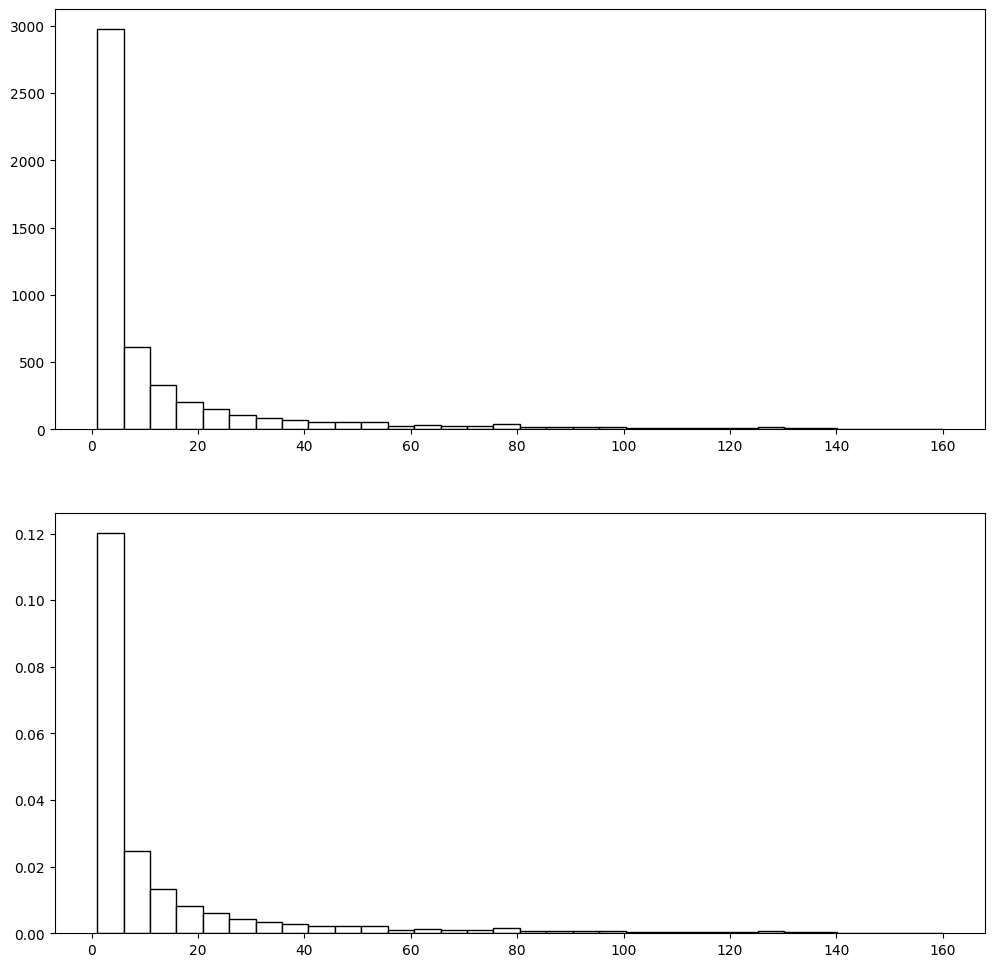

In [7]:
adj_mat_pearson_edge = np.where(adj_mat_pearson!=0,1,0)

#plot degrees
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (12, 12))
ax1.hist(adj_mat_pearson_edge.sum(axis=0),bins=32,edgecolor='black',color='white',density=False)
ax2.hist(adj_mat_pearson_edge.sum(axis=0),bins=32,edgecolor='black',color='white',density=True)
plt.show()

In [8]:
genes_associated_wnt=cross_tt[cross_tt['all']==1].index.tolist()
cross_genes=set(genes_associated_wnt).intersection(set(adj_mat_pearson.columns.tolist()))

In [9]:
#get position 
pos_cross_genes = [adj_mat_pearson.columns.get_loc(g) for g in cross_genes]

In [10]:
nodes = []
se = SearchEdge(adj_mat=np.array(adj_mat_pearson))
for i,start_node in enumerate(pos_cross_genes):
    se.dijkstra_optim(start_node=start_node,inplace=True)
    for end_node in pos_cross_genes[i:]:
        nodes += se.get_path(end_node=end_node)
nodes = set(nodes)

In [11]:
def gen_nodes_in_path(path:list):

        for i in path:
            for j in path:
                if i!=j:
                    yield i,j

def mask_adj_mat(path:list,adj_mat:np.ndarray=None):

    mask = np.zeros_like(adj_mat)

    
    for i,j in gen_nodes_in_path(path):
        mask[i,j]+=1

    mask_adj_mat = adj_mat*mask

    return mask_adj_mat

In [12]:
mask_adj_mat=mask_adj_mat(path=nodes,adj_mat=adj_mat_pearson)

In [13]:
genes_network = [adj_mat_pearson.columns[i] for i in set(np.where(mask_adj_mat!=0)[0])]

In [14]:
adj_mat_network = adj_mat_pearson.loc[genes_network,genes_network]
#genes_network 

In [15]:
adj_mat_network.shape

(79, 79)

In [16]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

class NetworkPearson:
    
    def __init__(self,adj_mat:np.ndarray=None,genes:list=None,_seed=42):
        self.adj_mat=adj_mat
        self.genes=genes
        self._seed=_seed
        self.graph=nx.Graph()

    def add_nodes(self):
        self.graph.add_nodes_from(self.genes)

    def add_edges(self):

        adj_mat_triu = np.triu(self.adj_mat,k=1)
        adj_mat_idx = np.where(adj_mat_triu!=0)

        for i,j in zip(*adj_mat_idx):
            node1=self.genes[i]
            node2=self.genes[j]
            if not self.graph.has_edge(node1,node2):
                self.graph.add_edge(node1,node2,weight=self.adj_mat[i,j])

    def get_weigths(self):
        return [self.graph[u][v]['weight'] for u,v in self.graph.edges()]

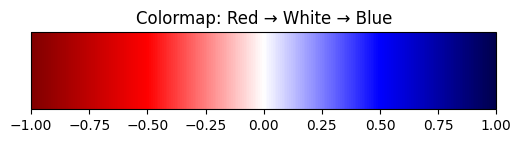

In [17]:
cmap = cm.seismic_r  # red -> white -> blue
norm = mcolors.Normalize(vmin=-1, vmax=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig, ax = plt.subplots(figsize=(6, 1))
fig.colorbar(sm, cax=ax, orientation='horizontal')
ax.set_title('Colormap: Red → White → Blue')

plt.show()

In [18]:
graph_wnt_pearson = NetworkPearson(adj_mat=np.array(adj_mat_network),genes=adj_mat_network.columns.tolist())
graph_wnt_pearson.add_nodes()
graph_wnt_pearson.add_edges()
weights=graph_wnt_pearson.get_weigths()
edges_colors=[cmap(norm(weight)) for weight in weights]

In [19]:
target_color = 'tomato'
secondary_target='coral'
default_color = 'gainsboro'
node_cmap = [(target_color if gene in list(cross_genes) else default_color) for gene in graph_wnt_pearson.genes]
for i,g in enumerate(graph_wnt_pearson.genes):
    if g == 'OR4K14':
        node_cmap[i]=secondary_target

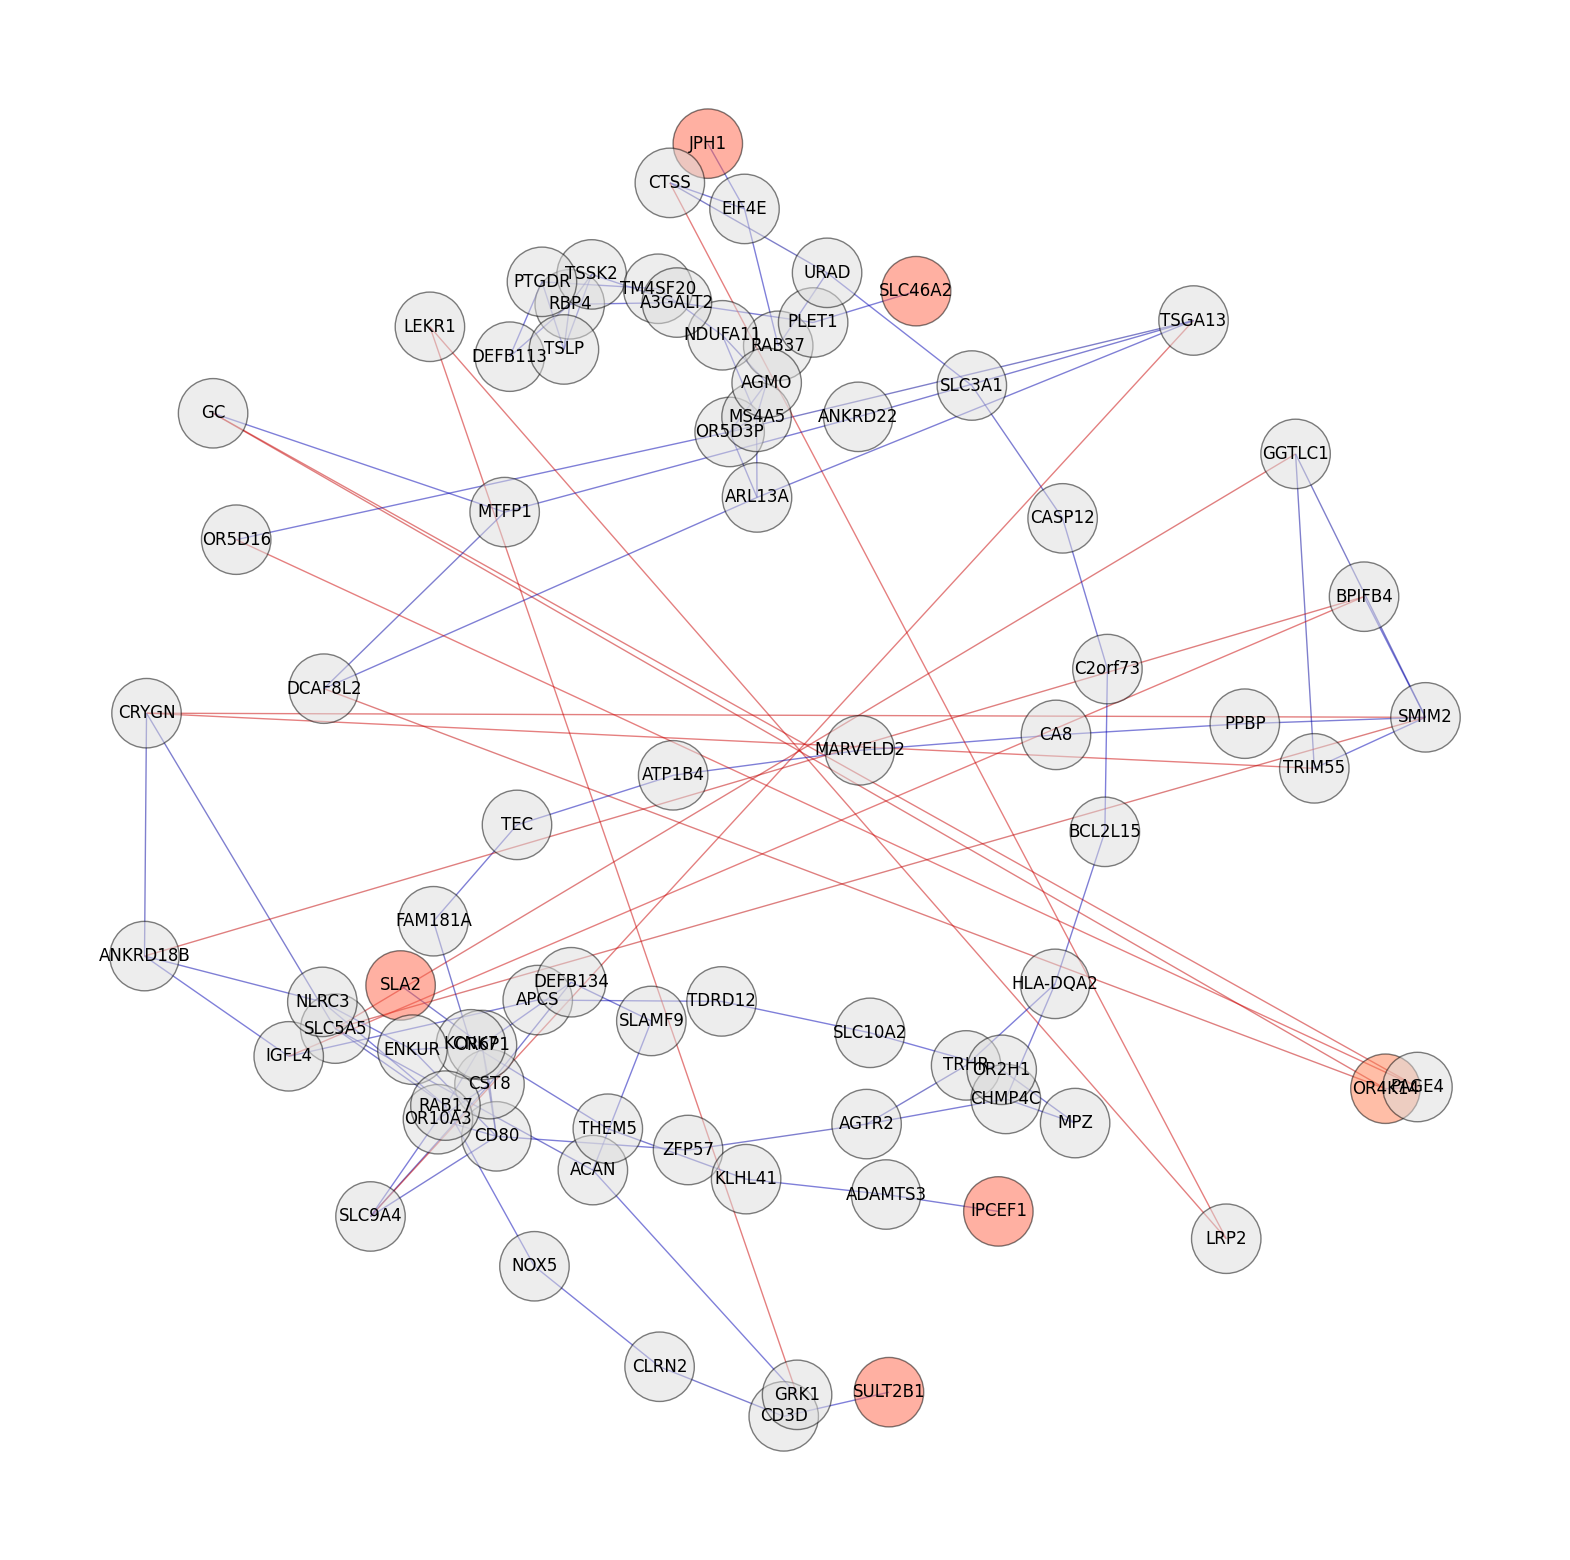

In [20]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(graph_wnt_pearson.graph, seed=42, k=0.2)
nx.draw_networkx_nodes(graph_wnt_pearson.graph, pos, node_size=2500, node_color=node_cmap,alpha=0.5,edgecolors='black')
nx.draw_networkx_edges(graph_wnt_pearson.graph, pos, edge_color=edges_colors, alpha=0.5)
nx.draw_networkx_labels(graph_wnt_pearson.graph, pos)

plt.axis('off')
plt.show()

In [21]:
path_data_network='/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/network/'
graph_wnt_pearson_corr=pd.DataFrame(data=graph_wnt_pearson.adj_mat,index=graph_wnt_pearson.genes,columns=graph_wnt_pearson.genes)
graph_wnt_pearson_corr.to_csv(path_data_network + 'adj_mat_pearson_wnt_target_mannwhitneyu.csv')

In [30]:
graph_wnt_pearson_corr.shape

(79, 79)

In [31]:
mi_matrix_edge=pd.read_csv('/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/network/mi_matrix_edge.csv',index_col=0)

In [34]:
set_col1 = set(mi_matrix_edge.columns.tolist())

In [35]:
set_col2=set(graph_wnt_pearson_corr.columns.tolist())

In [40]:
set_col2.difference(set_col1)

{'ARL13A', 'CST8', 'DEFB113', 'MS4A5', 'OR10A3', 'RBP4', 'TRHR'}

In [25]:
#mi_matrix_edge.loc[graph_wnt_pearson_corr.columns.tolist(),graph_wnt_pearson_corr.columns.tolist()]

In [26]:
def adjacenty_from_matrix_to_list(adj_mat:np.ndarray) -> defaultdict:

    adj_list = defaultdict(list)

    for i,j in zip(*np.where(np.triu(adj_mat))):
        adj_list[i].append([j,adj_mat[i,j]])
        adj_list[j].append([i,adj_mat[j,i]])

    return adj_list

In [27]:
adj_list_network=adjacenty_from_matrix_to_list(adj_mat=np.array(adj_mat_network))

In [28]:
(set(cross_tt[cross_tt['all']!=1].index.tolist())).intersection(graph_wnt_pearson.genes)

{'OR4K14'}

# Add mi

In [ ]:
genes_associated_wnt